## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

In [1]:
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("../")
import models_mae
import librosa
import librosa.display

### Define utils

In [16]:
# define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128),decoder_mode=1, decoder_depth=16)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model


In [3]:
MELBINS=128
TARGET_LEN=1024
def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, 
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)
    # AudioSet: 1024 (16K sr)
    # ESC: 512 (8K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

In [4]:
def display_fbank(bank, minmin=None, maxmax=None):
    #print(bank.shape, bank.min(), bank.max())
    #plt.figure(figsize=(18, 6))
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    #plt.colorbar()
    #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
    #S_db = bank.T.numpy()
    #plt.figure()
    #librosa.display.specshow(10*bank.T.numpy())
    #plt.colorbar()

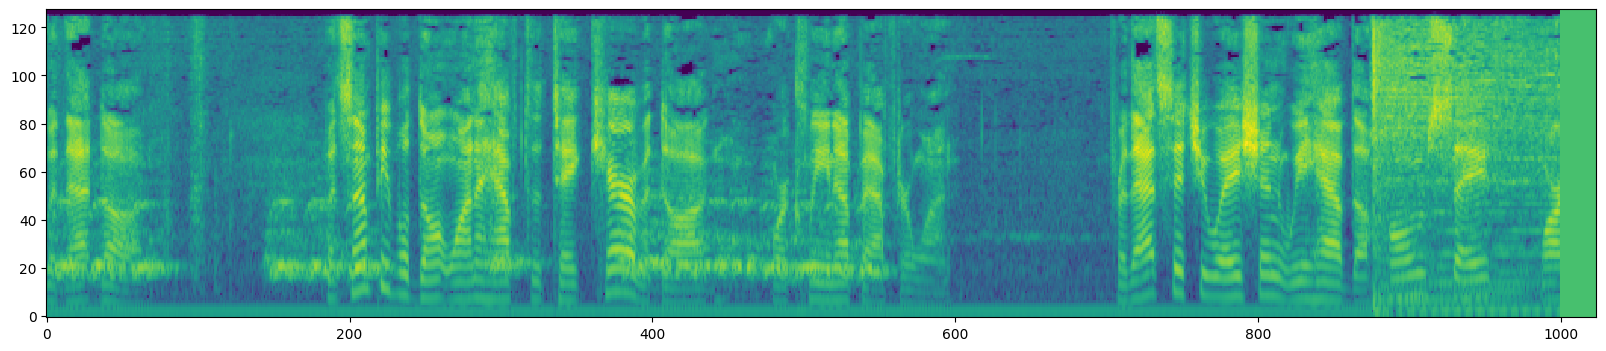

In [5]:
# wav_file = '/large_experiments/cmd/audioset/balance_wav/zye7IPXojSc.wav'
wav_file = 'zye7IPXojSc_30.0-40.0.mp3'
#wav_file = '/large_experiments/cmd/audioset/balance_wav/1JmYeNQ1jEI.wav'
fbank = wav2fbank(wav_file)
fbank = norm_fbank(fbank)
display_fbank(fbank)

In [71]:
#y, sr = librosa.load(wav_file)
#M = librosa.feature.melspectrogram(y=y, sr=sr)
#M_db = librosa.power_to_db(M, ref=np.max)
#plt.figure()
#librosa.display.specshow(M_db, y_axis='mel', x_axis='time')
#plt.colorbar()

In [17]:
#chkpt_dir = '/checkpoint/berniehuang/experiments/53417041/checkpoint-80.pth'
# chkpt_dir = '/checkpoint/berniehuang/experiments/53636601/checkpoint-19.pth'
chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/AS_2M/pretrained.pth'
model = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

/home/pythonuser/py_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>
Model loaded.


In [18]:
x = torch.tensor(fbank)
print(x.shape)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = x.unsqueeze(dim=0)
print(x.shape)
#x = torch.einsum('nhwc->nchw', x)

torch.Size([1024, 128])
torch.Size([1, 1, 1024, 128])


/tmp/ipykernel_1418687/2277072120.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


In [19]:
# run MAE
loss, y, mask,_ = model(x.float(), mask_ratio=0.1)
print('y_shape:',y.shape, mask.shape)
y = model.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()



y_shape: torch.Size([1, 512, 256]) torch.Size([1, 512])


In [20]:
# visualize the mask
mask = mask.detach()
#mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)
print(mask.shape)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', x)

# masked image
im_masked = x * (1 - mask) 

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask



#x[0]
#im_masked[0]
#y[0]
#im_paste[0], "reconstruction + visible")


torch.Size([1, 512, 256])


In [21]:
minmin = np.min([x[0].min(), im_masked[0].min(), y[0].min(), im_paste[0].min()])
maxmax = np.max([x[0].max(), im_masked[0].max(), y[0].max(), im_paste[0].max()])
minmin *= 10
maxmax *= 1
minmin=-10
maxmax=10
start=300
end=900
print(minmin,maxmax)

-10 10


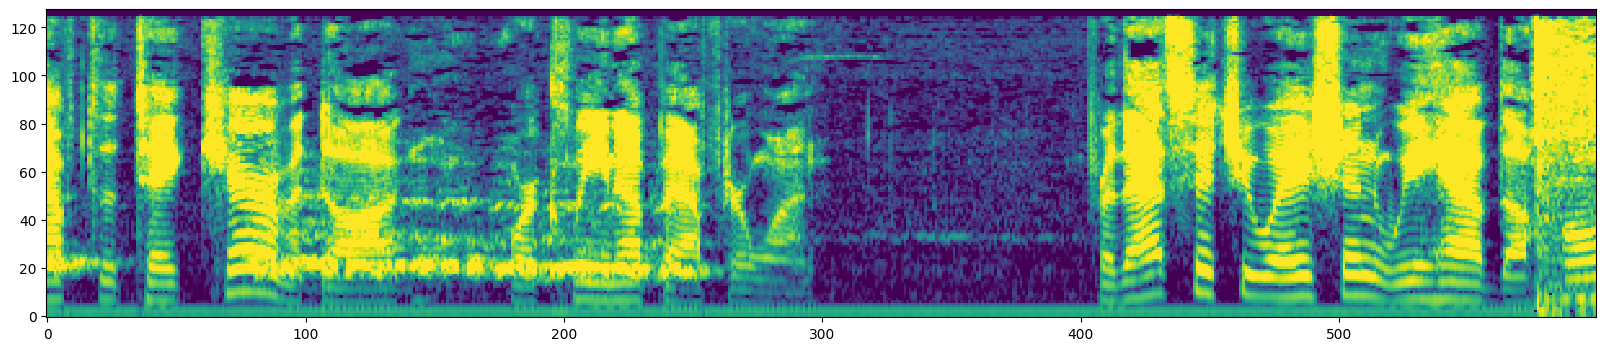

In [22]:
display_fbank(x[0][start:end].squeeze(), minmin=minmin, maxmax=maxmax)

In [23]:
im_masked2 = im_masked + (mask)*-10

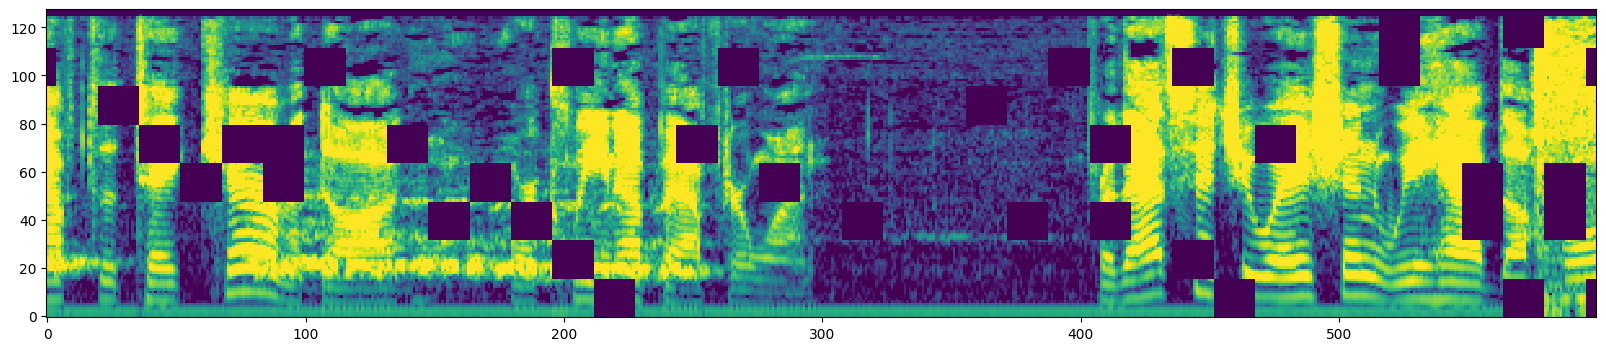

In [24]:
display_fbank(im_masked2[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

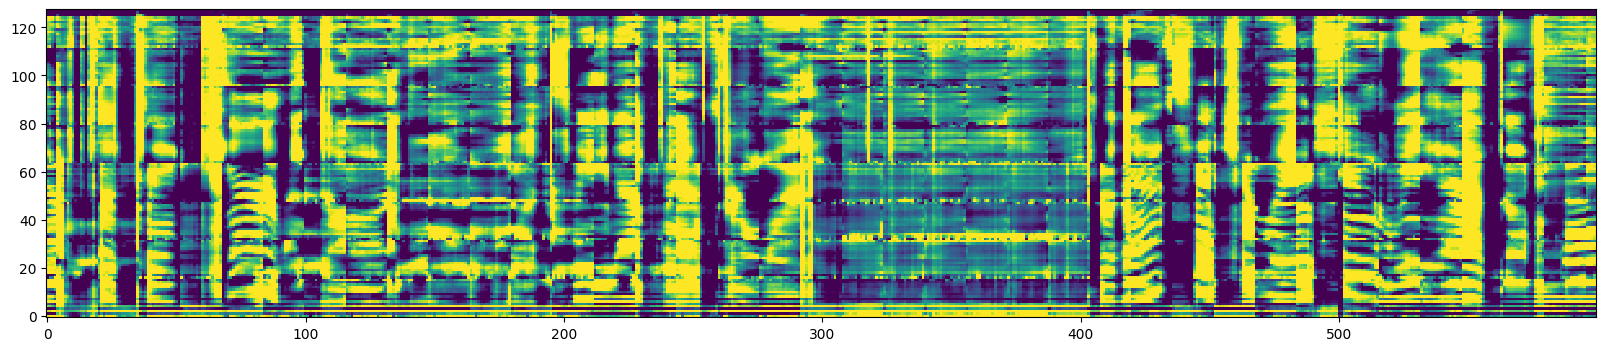

In [25]:
display_fbank((y[0][start:end]).squeeze(), minmin=minmin, maxmax=maxmax)

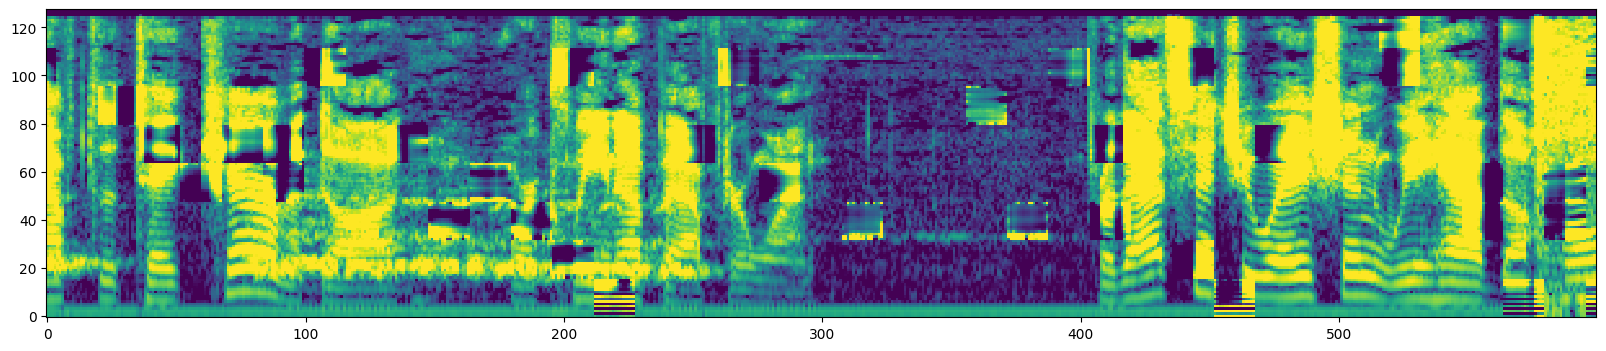

In [26]:
display_fbank(im_paste[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

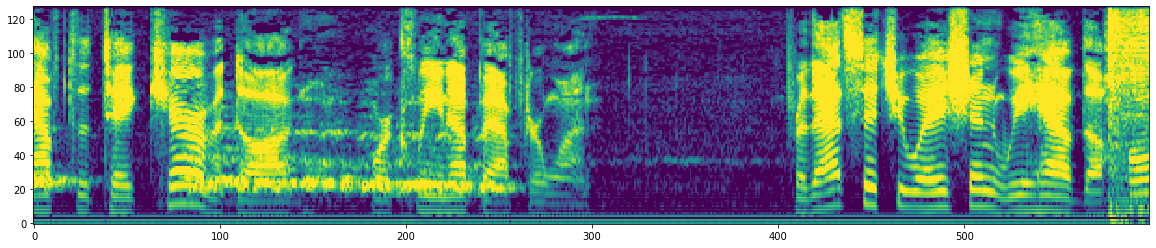

In [77]:
display_fbank(x[0][start:end].squeeze(), minmin=minmin, maxmax=maxmax)

In [78]:
im_masked2 = im_masked + (mask)*-10

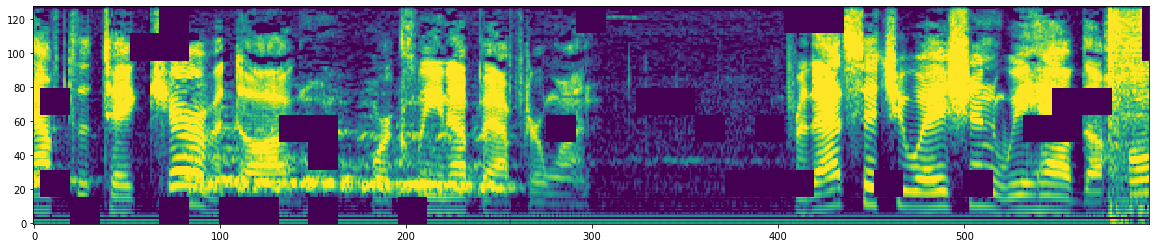

In [79]:
display_fbank(im_masked2[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

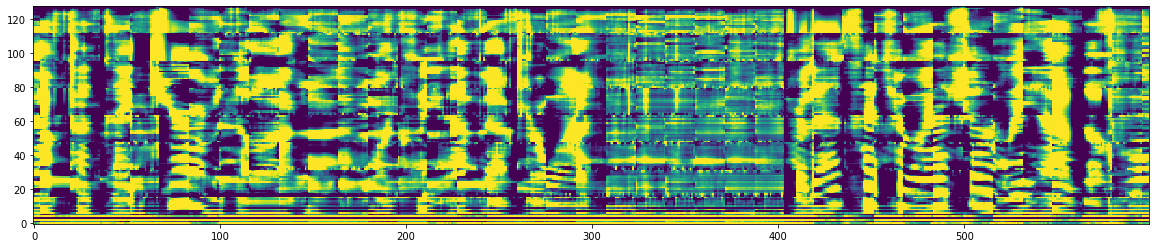

In [80]:
display_fbank((y[0][start:end]).squeeze(), minmin=minmin, maxmax=maxmax)

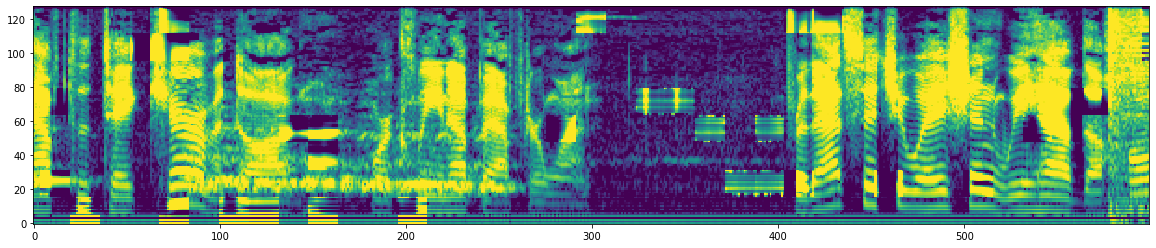

In [81]:
display_fbank(im_paste[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

In [60]:
# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

In [25]:
#display_fbank((y * mask - 999).squeeze())